# Datenaufbereitung - Vorgehen
Dieses Dokument beschreibt den Prozess der Datenaufbereitung vom Laden aus der MongoDB bis zum exportieren der Trainingsdatensätze als csv.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import copy
import importbib

## Herunterladen der Daten aus der MongoDB
Als erstes werden die Daten für einen bestimmten Zeitabschnitt über die Funktion loadTimeframeFromMongoDB heruntergeladen. Start- und Endzeitpunkt des Reibvorgans müssen in etwa bekannt sein. Der angegebene Zeitrahmen muss größer gewählt werden, sodass auf jeden Fall alle Reibdaten enthalten sind. **Achtung**: Während dem Download muss der entsprechende Rechner im VPN der Hochschule sein.

In [ ]:
dtStart = datetime(2019,11,26,12,0)
dtEnd = datetime(2019,11,26,23,59)
dfTimeFrame = importbib.loadTimeframeFromMongoDB(dtStart,dtEnd)
dfTimeFrame.to_csv("csv_Files/2019-11-26_export.csv", index=False, sep=",", encoding="utf-8")

Bereits heruntergeladene Daten können über die normale Pandasfunktion read_csv gelesen werden. Timestampfelder müssen dann aber noch umgewandelt werden:

In [6]:
dfTimeFrame = pd.read_csv("csv_Files/2019-11-26_export.csv", encoding="utf-8")
dfTimeFrame.timeStamp = pd.to_datetime(dfTimeFrame.timeStamp)
dfTimeFrame.dtypes

_id                  object
ValueID              object
value               float64
timeStamp    datetime64[ns]
dtype: object

Zur visuellen Kontrolle können die Daten der Z-Achse, und die Logdaten weiterer Komponenten geplottet werden. Dazu steht die Hilfsfunktion plotSpecificIDs bereit:

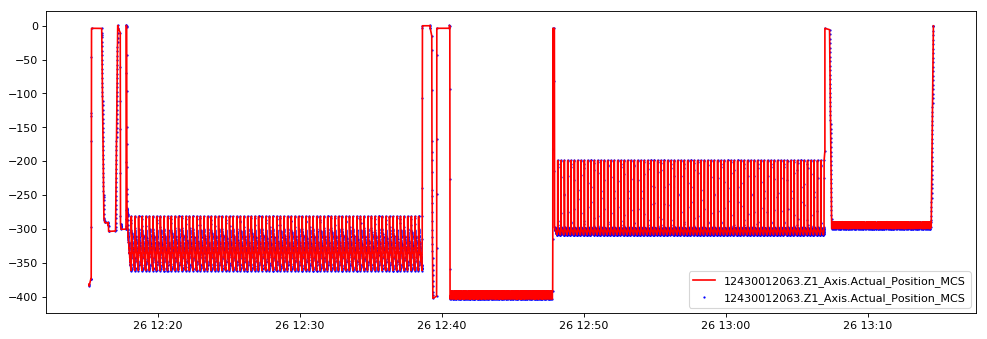

In [7]:
importbib.plotActualZ1(dfTimeFrame, saveFile=False)

In diesem Zeitabschnitt sind neben dem Reiben auch bohren und entgraten zu sehen. Um diesen Vorgang eindeutig von den Anderen unterscheiden zu können, benötigen wir die Daten aus MongoDB-Collection values_ncprogram. Mithilfe der importbib können diese einfach von der MongoDB geladen werden:

In [9]:
dtStart = datetime(2019,11,26,12,0)
dtEnd = datetime(2019,11,26,23,59)
dfReibdaten = importbib.loadReibdatenFromMongoDB(dtStart,dtEnd)
dfReibdaten.to_csv("csv_Files/2019-11-26_reibdaten.csv", index=False, sep=",", encoding="utf-8")
dfReibdaten.head()

0, 10000, 

,_id,ValueID,value,timeStamp,progName,toolNo
0,5ddd1ea38e15b3086c06b050,12430012063.Channel1.Feed_Axis,40000.000000,2019-11-26 12:47:47.857,REIBEN.MPF,RA_12H7
1,5ddd1ea38e15b3086c06b056,12430012063.Channel1.Program_Feed,40000.000000,2019-11-26 12:47:47.870,REIBEN.MPF,RA_12H7
2,5ddd1ea38e15b3086c06b057,12430012063.Channel1.Spindle_Speed,0.000000,2019-11-26 12:47:47.871,REIBEN.MPF,RA_12H7
3,5ddd1ea38e15b3086c06b067,12430012063.Channel1.Feed_Axis,12864.037984,2019-11-26 12:47:47.949,REIBEN.MPF,RA_12H7
4,5ddd1ea38e15b3086c06b068,12430012063.Channel1.Program_Feed,12864.037984,2019-11-26 12:47:47.953,REIBEN.MPF,RA_12H7


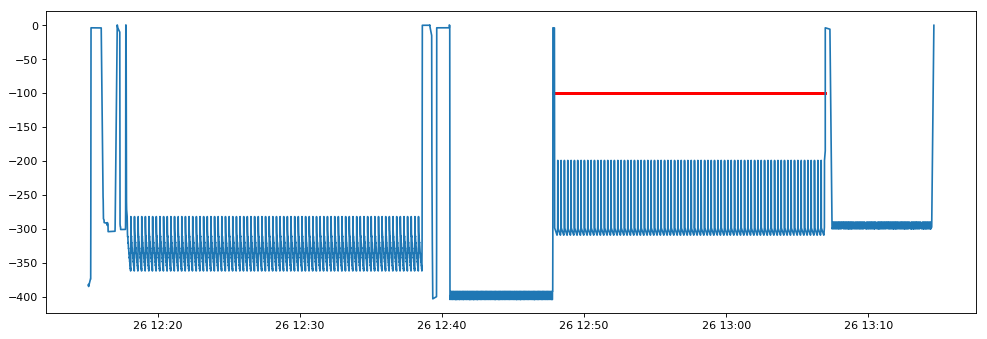

In [15]:
fig = plt.figure(figsize=(15, 5), dpi=80)
zAxisData = dfTimeFrame.loc[lambda l: l['ValueID'] == "12430012063.Z1_Axis.Actual_Position_MCS",:]
plt.plot(zAxisData.timeStamp,zAxisData.value)
plt.scatter(dfReibdaten.timeStamp,[-100]*len(dfReibdaten), s=1.0,c='r')